In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [4]:
BASE_DIR = "data"

Keras accepts 3 types of data

1. Numpy array - if data fits in memory
2. Tensorflow Dataset - useful for datasets that dont fit in memory
    - useful for
        - asynchronous preprocessing of data on CPU when GPU is busy and buffering to queue
        - prefetching data on GPU so that its available immediately when the GPU is finished with previous batch
3. Python generators - yeilds batch of data [custom subclasses of keras.utils.Sequence]

Keras has a lot of utility function to turn raw data into Dataset

    - tf.keras.preprocessing.image_dataset_from_directory
    - tf.keras.preprocessing.text_dataset_from_directory

In [11]:
# example directory
import os
ex1_sample = os.path.join(BASE_DIR, "sample_images")
ex1_dataset = keras.preprocessing.image_dataset_from_directory(ex1_sample, batch_size=64, image_size=(200,200))

# lets iterate throught the dataset
for data, label in ex1_dataset:
    print(data.shape)
    print(data.dtype)
    print(label.shape)
    print(label.dtype)

Found 7 files belonging to 4 classes.
(7, 200, 200, 3)
<dtype: 'float32'>
(7,)
<dtype: 'int32'>


Using Keras preprocessing layers

In Keras, you do in-model data preprocessing via preprocessing layers. This includes:

Vectorizing raw strings of text via the TextVectorization layer
Feature normalization via the Normalization layer
Image rescaling, cropping, or image data augmentation
The key advantage of using Keras preprocessing layers is that they can be included directly into your model, either during training or after training, which makes your models portable.

Some preprocessing layers have a state:

TextVectorization holds an index mapping words or tokens to integer indices
Normalization holds the mean and variance of your features

In [21]:
### turning strings into sequence of words

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

training_data = np.array([["This is the first sample"],["This is the second sample"]])

# creating a text vectorization layer instance, and return integer token instances
# or a dense token representation like a one-hot or TF-IDF
vectorizer = TextVectorization(output_mode='int')

# adapt method is used to generate a vocabulary
vectorizer.adapt(training_data)

# after calling adapt, the layer is able to encode any n-gram it has seen before 
# in the adapt method earlier

integer_data = vectorizer(training_data)
print(integer_data)

tf.Tensor(
[[2 5 3 7 4]
 [2 5 3 6 4]], shape=(2, 5), dtype=int64)


In [23]:
### Converting strings to one-hot encoded bigrams

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

traning_data = np.array([["This is the first sample"], ["This is the second sample"]])

vectorizer = TextVectorization(output_mode='binary', ngrams=2)

vectorizer.adapt(training_data)

integer_data = vectorizer(training_data)
print(integer_data)

tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0.]], shape=(2, 13), dtype=float32)


### Normalizing the features

In [26]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization

training_data = np.random.randint(0,256, size=(64, 200, 200, 3)).astype("float32")

In [29]:
training_data.shape

(64, 200, 200, 3)

In [27]:
normalizer = Normalization(axis=1)
normalizer.adapt(training_data)

In [28]:
normalized_data = normalizer(training_data)
print("var: %.4f" % np.var(normalized_data))
print("mean: %.4f" % np.mean(normalized_data))

var: 1.0000
mean: -0.0000


### Rescaling a center cropping images

In [30]:
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

training_data = np.random.randint(0, 256, size=(64,200,200,3)).astype("float32")

cropper = CenterCrop(height=150, width=150)
scaler = Rescaling(scale=1.0 / 255)

output_data = scaler(cropper(training_data)) # pipelined
print("shape: ", output_data.shape)
print("min: ", np.min(output_data))
print("max: ", np.max(output_data))

shape:  (64, 150, 150, 3)
min:  0.0
max:  1.0


### Building models with keras functional APIs

In [31]:
inputs = keras.Input(shape=(None, None, 3)) # this will accept image of any size, 3 channel

In [32]:
from tensorflow.keras import layers

In [35]:
x = CenterCrop(height=150, width=150)(inputs)
x = Rescaling(scale=1.0/255)(x)

# Applying convolutions and max-polling
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)

# Applying global average pooling to get flat feature vectors
x = layers.GlobalAveragePooling2D()(x)

# Adding dense classifier on top
num_classes = 10
outputs = layers.Dense(num_classes, activation="softmax")(x)

In [36]:
model = keras.Model(inputs=inputs, outputs=outputs)

In [38]:
data = np.random.randint(0, 256, size=(64,200,200,3)).astype('float32')
out_data = model(data)
#### input_shape
print(data.shape)
#### output shape
print(out_data.shape)

(64, 200, 200, 3)
(64, 10)


In [40]:
# Printing a summary of how the data is getting transformed down
# this pipeline

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
center_crop_3 (CenterCrop)   (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0     

### Understaing the above table

```
The input is of shape (N*I*I*C)
# Conv2D
The next layer say conv2D - has K      - no of filters
                                F      - filter or kernel size(FxF)
                                S      - stride
                                Pstart - start padding
                                Pend   - end of padding
                 Dimension of filter   - F * F * C
        Output size of feature map(O)  - (I - F + Pstart + Pend)/S + 1
                       Output Size     - OxOxK
                    Number of params   - (F*F*C+1)*K
                    
 
 # MaxPooling2D
                     Output Size       - OxOxC
                  Number of paramerts  - 0
                  

# FCN
                         Output Size   - No_of_classes
                       Num of params   - (Nin + 1)* Out Size
     
                                
                               
                               
Note: 3 types of padding
    1) Zero padding - Pstart == Pend == 0
    2) Same padding - Pstart = S[I/S]-I+F-S/2
                      Pend   = S[I/S]-I+F-S/2
    3) Full padding   Pstart = [0, F-1]
                      Pend = F-1
```

```
First Conv(K=32, F=3, I =150, C = 3, P=0)
    No.of params = (F*F*C+1)*K 
                 = (3*3*3+1)*32 = 896    -----------1
        
    Output(O) =  (150-3)+1 = 148        
    Output Shape = OxOxK = 148*148*32

MaxPool Layer1 (F=3, I = 148, C=32)
    No of params = 0
    Output (O) = floor[I/F] = 49
    Output Shape = OxOxK = 49*49*32
            

Second Conv(K=32, F=3, I = 49, C=32, P=0)
      No. of params = (F*F*C+1)*K = 9248   ----------2
      Output(O) =  I - F + 2P/S +1 = (49-3)+1 = 47
      Output Shape = 47*47*32
      
MaxPool Layer 2(F=3, I = 47, C=32)
    No of params = 0
    Output(O) = floor[I/F] = 15
    Output Shape = 15*15*32 (O*O*C)
    
Third Conv(K=32, F=3, I=15, P=0, C =32)
      No. of params = (F*F*C+1)*K = 9248    ----------3
      Output(O) = (I - F  + 2P)/S +1 = (15-3)+1 = 13
      Output Shape = 13*13*32
      
Global Average Pooling Layer will only - C dim (I=13, C=32)
         No. of params = 0
         Output Shape = 32 , (I is averaged)

Dense   (I=32, O=10)
        No. of params = (32+1)*10 = 330     -----------4
        Output Shape = 10
      
      
Total params = 896 + 2 * (9248) + 330 = 19,722 [trainable params (FC+CNN)] 
```

### Now that we have model and data, we will train

In [45]:
model.compile(optimizer=
              keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.CategoricalCrossentropy())

### Once the model is compiled, we will try to fir the data to the model

In [ ]:
model.fit(numpy_arrays_of_samples, 
          numpy_array_of_labels, 
          batch_size=32,
          epochs=10)

### Toy example - MNIST

In [51]:
# Get the data as Numpy arrays
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Build a simple model
inputs = keras.Input(shape=(28, 28))
x = Rescaling(1.0 / 255)(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

# Train the model for 1 epoch from Numpy data
batch_size = 64
print("Fit on NumPy data")
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1)

# Train the model for 1 epoch using a dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
print("Fit on Dataset")
history = model.fit(dataset, epochs=100)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_____________________________________________________

In [52]:
print(history.history)

{'loss': [0.11538337171077728, 0.07739068567752838, 0.05588624253869057, 0.041063304990530014, 0.030807601287961006, 0.025458209216594696, 0.02145235612988472, 0.01987391896545887, 0.02032712660729885, 0.014030501246452332, 0.016062753275036812, 0.010846823453903198, 0.012881933711469173, 0.011789713986217976, 0.00826964806765318, 0.01346042100340128, 0.008084124885499477, 0.008270231075584888, 0.009916430339217186, 0.007499664090573788, 0.00874023512005806, 0.009303811937570572, 0.0076078143902122974, 0.00893585104495287, 0.006909180898219347, 0.006265826988965273, 0.0063356682658195496, 0.008525144308805466, 0.0036899938713759184, 0.008277119137346745, 0.006698316428810358, 0.008872058242559433, 0.007671100553125143, 0.006016954779624939, 0.003829379566013813, 0.005144134163856506, 0.005758003797382116, 0.007364135235548019, 0.003244301537051797, 0.004738905001431704, 0.008858981542289257, 0.004137018695473671, 0.003344170982018113, 0.008132550865411758, 0.0048753139562904835, 0.0047

In [56]:
print(history.history.keys())

dict_keys(['loss'])


#### Plotting the loss function

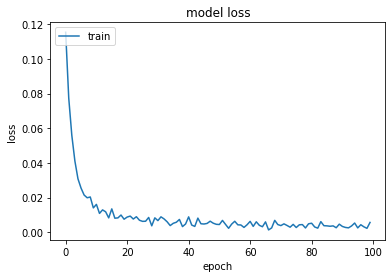

In [57]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [58]:
#### Tracking performance metrics for the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
history = model.fit(dataset, epochs=1)

938/938 [==============================] - 3s 1ms/step - loss: 0.0041 - acc: 0.9994


### Passing validation data to fit

In [64]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
history = model.fit(dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0059 - acc: 0.9967 - val_loss: 0.2466 - val_acc: 0.9966
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 0.9966 - val_loss: 0.2563 - val_acc: 0.9966
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.9967 - val_loss: 0.2327 - val_acc: 0.9966
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0011 - acc: 0.9967 - val_loss: 0.2351 - val_acc: 0.9967
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 0.9967 - val_loss: 0.2660 - val_acc: 0.9967
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0076 - acc: 0.9967 - val_loss: 0.2623 - val_acc: 0.9967
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 5.5225e-04 - acc: 0.9967 - val_loss: 0.2404 - val_acc: 0.9967
Epoch 8/50
938/938 [==============================] - 1s 1ms/step - loss

In [65]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


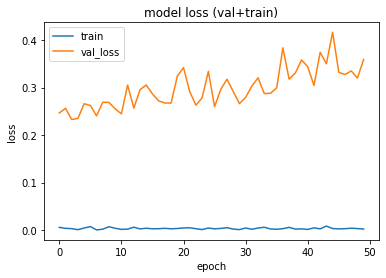

In [66]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (val+train)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'], loc='upper left')
plt.show()

```
Based on the above plot, looks like we need 4-fold cross validation
since the validation set which is the test set, doesnt follow similar trend
```

### Checkpointing model training
```
Its important to checkpoint the training to recover from a long training job
Also its important in a distributed training scenario, where workers fail

Callbacks are a way to make model training entirely scriptable.
```

In [67]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(BASE_DIR,"checkpoint"),
        save_freq='epoch')
]
model.fit(dataset, epochs=2, callbacks=callbacks)

Epoch 1/2
938/938 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.9967
INFO:tensorflow:Assets written to: data/checkpoint/assets
Epoch 2/2
938/938 [==============================] - 1s 1ms/step - loss: 0.0025 - acc: 0.9967
INFO:tensorflow:Assets written to: data/checkpoint/assets


### Monitoring real-time progress using tensorboard
```
We will use a callback to capture log and render on a real-time UI
for model training updates - callend tensorboard
```

In [74]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir='./logs')
]
model.fit(dataset, epochs=50, callbacks=callbacks)

Epoch 1/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0060 - acc: 0.9978
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0022 - acc: 0.9978
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 8.5827e-04 - acc: 0.9978
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0020 - acc: 0.9978
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0023 - acc: 0.9978
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0049 - acc: 0.9978
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 7.8186e-04 - acc: 0.9979
Epoch 8/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0042 - acc: 0.9979
Epoch 9/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0047 - acc: 0.9979
Epoch 10/50
938/938 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.9979
Epoch 11/50
938/938 [====================

#### run this on terminal
#!tensorboard --logdir=./logs

### Evaluating Test Data

In [75]:
loss, acc = model.evaluate(val_dataset)  # returns loss and metrics
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)

157/157 [==============================] - 0s 793us/step - loss: 0.4749 - acc: 0.9982
loss: 0.47
acc: 1.00


In [76]:
predictions = model.predict(val_dataset)
print(predictions.shape)

(10000, 10)


### Custom Model for training

In [ ]:
class CustomModel(keras.Model):
  def train_step(self, data):
    # Unpack the data. Its structure depends on your model and
    # on what you pass to `fit()`.
    x, y = data
    with tf.GradientTape() as tape:
      y_pred = self(x, training=True)  # Forward pass
      # Compute the loss value
      # (the loss function is configured in `compile()`)
      loss = self.compiled_loss(y, y_pred,
                                regularization_losses=self.losses)
    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    # Update metrics (includes the metric that tracks the loss)
    self.compiled_metrics.update_state(y, y_pred)
    # Return a dict mapping metric names to current value
    return {m.name: m.result() for m in self.metrics}

# Construct and compile an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

callbacks = [
    keras.callbacks.TensorBoard(log_dir='./logs')
]

# Just use `fit` as usual
model.fit(dataset, epochs=3, callbacks=callbacks)

### Debugging your model with eager execution

If you write custom training steps or custom layers, you will need to debug them. The debugging experience is an integral part of a framework: with Keras, the debugging workflow is designed with the user in mind.

By default, your Keras models are compiled to highly-optimized computation graphs that deliver fast execution times. That means that the Python code you write (e.g. in a custom train_step) is not the code you are actually executing. This introduces a layer of indirection that can make debugging hard.

Debugging is best done step by step. You want to be able to sprinkle your code with print() statement to see what your data looks like after every operation, you want to be able to use pdb. You can achieve this by running your model eagerly. With eager execution, the Python code you write is the code that gets executed.

Simply pass run_eagerly=True to compile():

model.compile(optimizer='adam', loss='mse', run_eagerly=True)
Of course, the downside is that it makes your model significantly slower. Make sure to switch it back off to get the benefits of compiled computation graphs once you are done debugging!

In general, you will use run_eagerly=True every time you need to debug what's happening inside your fit() call.

### Asynchronous Pre-processing

```
Data processing happens in CPU and the GPU is good with feature normalization/data aug.

Asynchronous multi-processing is useful to pre-fetch data to be fed to the gpu, while gpu is sill
working on previous data, to keep gpu fully utilized

In keras, we use dataset.map to achieve this

```

In [78]:
# Example training data, of dtype `string`.
samples = np.array([["This is the 1st sample."], ["And here's the 2nd sample."]])
labels = [[0], [1]]

# Prepare a TextVectorization layer.
vectorizer = TextVectorization(output_mode="int")
vectorizer.adapt(samples)

# Asynchronous preprocessing: the text vectorization is part of the tf.data pipeline.
# First, create a dataset
dataset = tf.data.Dataset.from_tensor_slices((samples, labels)).batch(2)
# Apply text vectorization to the samples
dataset = dataset.map(lambda x, y: (vectorizer(x), y))
# Prefetch with a buffer size of 2 batches
dataset = dataset.prefetch(2)

# Our model should expect sequences of integers as inputs
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(input_dim=10, output_dim=32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", run_eagerly=True)
model.fit(dataset)

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.embedding_lookup), but
are not present in its tracked objects:
  <tf.Variable 'embedding/embeddings:0' shape=(10, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.tensordot), but
are not present in its tracked objects:
  <tf.Variable 'dense_7/kernel:0' shape=(32, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'dense_7/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior

### Hyperparameter Tuning - using Keras Tuner
```
First, place your model definition in a function, that takes a single hp argument.

Inside this function, replace any value you want to tune with a call to hyperparameter sampling methods, e.g. hp.Int() or hp.Choice():
```

In [84]:
def build_model(hp):
    inputs = keras.Input(shape=(784,))
    x = layers.Dense(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        activation='relu')(inputs)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

The function should return a compiled model.

Next, instantiate a tuner object specifying your optimization objective and other search parameters:

In [87]:
import keras_tuner

tuner = keras_tuner.tuners.Hyperband(
  build_model,
  objective='val_loss',
  max_epochs=100,
  executions_per_trial=2,
  directory='my_dir')

TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.